In [8]:
import sys

sys.path.append('..')

In [46]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

In [47]:
transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

In [50]:
# dataset = ImageFolder(root='./datasets/people/', transform=transforms)

In [12]:
values, indices = torch.unique(torch.tensor(dataset.targets), return_counts=True)[1].sort(descending=True)

In [13]:
filtered = []
for i in range(len(values)):
    if values[i] > 50 and values[i] < 120:
        filtered.append(indices[i])

In [14]:
classes = [dataset.classes[i] for i in filtered]

In [30]:
paths = ["./datasets/people/" + cls for cls in classes]

In [31]:
from core.loader.image_loader import ImageLoader
from core.embed.face import FaceEmbedder
from tqdm import tqdm

loaders = [ImageLoader(path) for path in paths]

In [32]:
embedder = FaceEmbedder()

In [18]:
for loader in tqdm(loaders):
    loader.load()
    for img in loader.iter():
        emb = embedder.embed(img)

100%|██████████| 8/8 [09:04<00:00, 68.01s/it] 


In [84]:
import pickle

with open('./loader.pkl', 'rb') as f:
    loader = pickle.load(f)
loaders = [loader]

In [298]:
img_map = {}
cluster_ids = []
cluster_classes = []
cluster_dataset = []
cluster_size_map = {}
classes = ["1"] * len(loaders)
# for loader, clss in zip(loaders, classes):
#     cluster_size_map[clss] = 0
clss = '1'
cluster_size_map[clss] = 0
for img in loader.iter():
    img_map[img.id] = img
    for key, face in img.faces.items():
        cluster_ids.append(img.id)
        cluster_dataset.append(face['embedding'])
        cluster_classes.append(clss)
        cluster_size_map[clss] += 1

In [299]:
len(cluster_ids)

119

In [300]:
len(cluster_dataset), cluster_dataset[0].shape

(119, (1, 512))

## Visualizing by reducing dimensions with t-SNE

In [413]:
from dash import Dash, dcc, html, Input, Output, no_update, callback
import plotly.graph_objects as go
import io
import base64

from PIL import Image
import pandas as pd

In [406]:
from sklearn.manifold import TSNE
import numpy as np

X = np.array(cluster_dataset).reshape(-1, 512)
Y = np.array(cluster_ids)

In [407]:
def np_image_to_base64(im_matrix):
    im = Image.fromarray(im_matrix)
    buffer = io.BytesIO()
    im.save(buffer, format="jpeg")
    encoded_image = base64.b64encode(buffer.getvalue()).decode()
    im_url = "data:image/jpeg;base64, " + encoded_image
    return im_url

In [414]:
def tsne_plot(X, Y, n, kwargs):
    tsne = TSNE(n_components=n, **kwargs)
    X_2d = tsne.fit_transform(X)
    if n == 2:
        df = pd.DataFrame(X_2d, columns=["x", "y"])
    else:
        df = pd.DataFrame(X_2d, columns=["x", "y", "z"])

    df["id"] = Y
    df["class"] = "1"
    df["img"] = [img_map[i].image for i in Y]

    color_map = {
        0: "#E52B50",
        1: "#9F2B68",
        2: "#3B7A57",
        3: "#3DDC84",
        4: "#FFBF00",
        5: "#915C83",
        6: "#008000",
        7: "#7FFFD4",
    }

    colors = [color_map[classes.index(clss)] for clss in cluster_classes]

    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=df["x"],
                y=df["y"],
                z=df["z"],
                mode="markers",
                marker=dict(
                    size=2,
                    color=colors,
                ),
            )
        ]
    )

    fig.update_traces(
        hoverinfo="none",
        hovertemplate=None,
    )

    app = Dash(__name__)

    app.layout = html.Div(
        className="container",
        children=[
            dcc.Graph(id="graph-5", figure=fig, clear_on_unhover=True),
            dcc.Tooltip(id="graph-tooltip-5", direction="bottom"),
        ],
    )


    @callback(
        Output("graph-tooltip-5", "show"),
        Output("graph-tooltip-5", "bbox"),
        Output("graph-tooltip-5", "children"),
        Input("graph-5", "hoverData"),
    )
    def display_hover(hoverData):
        if hoverData is None:
            return False, no_update, no_update

        # demo only shows the first point, but other points may also be available
        hover_data = hoverData["points"][0]
        bbox = hover_data["bbox"]
        num = hover_data["pointNumber"]

        im_matrix = df["img"].iloc[num]
        im_url = np_image_to_base64(np.array(im_matrix))
        children = [
            html.Div(
                [
                    html.Img(
                        src=im_url,
                        style={"width": "150px", "display": "block", "margin": "0 auto"},
                    ),
                    html.P(str(df["class"].iloc[num]), style={"font-weight": "bold"}),
                ]
            )
        ]

        return True, bbox, children
    return app

In [418]:
# X_embedded = TSNE(n_components=3, perplexity=30, max_iter=10000, metric='cosine').fit_transform(X)

In [421]:
# app.run_server(debug=True)
tsne_plot(X, Y, 3, {'perplexity': 30, 'max_iter': 5000, 'metric': 'cosine'}).run_server(debug=True)

## Clustering with Community Detection

In [422]:
from sentence_transformers import util
def community_detection(embeddings, threshold, min_community_size=2, init_max_size=500):
    cos_scores = util.cos_sim(embeddings, embeddings)

    top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)

    extracted_communities = []
    for i in range(len(top_k_values)):
        if top_k_values[i][-1] >= threshold:
            new_cluster = []

            top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size, largest=True)
            top_idx_large = top_idx_large.tolist()
            top_val_large = top_val_large.tolist()

            if top_val_large[-1] < threshold:
                for idx, val in zip(top_idx_large, top_val_large):
                    if val < threshold:
                        break

                    new_cluster.append(idx)
            else:
                for idx, val in enumerate(cos_scores[i].tolist()):
                    if val >= threshold:
                        new_cluster.append(idx)

            extracted_communities.append(new_cluster)

    extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

    unique_communities = []
    extracted_ids = set()

    for community in extracted_communities:
        add_cluster = True
        for idx in community:
            if idx in extracted_ids:
                add_cluster = False
                break

        if add_cluster:
            unique_communities.append(community)
            for idx in community:
                extracted_ids.add(idx)

    return unique_communities

In [423]:
embeddings = np.array(cluster_dataset).reshape(-1, 512)

In [424]:
clusters = community_detection(embeddings, threshold=0.7, min_community_size=5, init_max_size=10)
len(clusters)

5

In [425]:
def report(clusters, cluster_classes, cluster_size_map):
    print(
        f"Classes \t   NClasses \t Cluster Size \t Actual Size \t Accuracy \t Precision \t Recall"
    )
    print("-" * 110)
    total_accuracy = 0
    total_precision = 0
    total_recall = 0
    for cluster in clusters:
        true_positives = 0
        false_positives = 0
        for i, c in enumerate(cluster):
            if cluster_classes[c] == cluster_classes[cluster[0]]:
                true_positives += 1
            else:
                false_positives += 1

        accuracy = true_positives / len(cluster)
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / cluster_size_map[cluster_classes[cluster[0]]]

        unique_classes = len(set([cluster_classes[c] for c in cluster]))

        total_accuracy += accuracy
        total_precision += precision
        total_recall += recall

        print(
            f"{cluster_classes[cluster[0]].ljust(20)} \t {unique_classes} \t {len(cluster):10d} \t {cluster_size_map[cluster_classes[cluster[0]]]:10d} \t {accuracy:8.2f} \t{precision:10.2f} \t{recall:7.2f}"
        )

    total_predictions = sum([len(cluster) for cluster in clusters])
    average_accuracy = total_accuracy / len(clusters)
    average_precision = total_precision / len(clusters)
    average_recall = total_recall / len(clusters)
    print("-" * 110)
    print(
        f"Total \t\t\t\t {total_predictions:10d} \t\t{len(cluster_dataset)} \t Avg {average_accuracy:.2f} \t{average_precision:10.2f} \t{average_recall:7.2f}"
    )

In [426]:
report(clusters, cluster_classes, cluster_size_map)

Classes 	   NClasses 	 Cluster Size 	 Actual Size 	 Accuracy 	 Precision 	 Recall
--------------------------------------------------------------------------------------------------------------
1                    	 1 	         12 	        119 	     1.00 	      1.00 	   0.10
1                    	 1 	          6 	        119 	     1.00 	      1.00 	   0.05
1                    	 1 	          6 	        119 	     1.00 	      1.00 	   0.05
1                    	 1 	          5 	        119 	     1.00 	      1.00 	   0.04
1                    	 1 	          5 	        119 	     1.00 	      1.00 	   0.04
--------------------------------------------------------------------------------------------------------------
Total 				         34 		119 	 Avg 1.00 	      1.00 	   0.06


Alright! 🙂

### UMAP + HDBSCAN

In [120]:
import umap
import hdbscan

In [435]:
umap_embs = umap.UMAP(n_components = 3, n_neighbors=4, metric='cosine').fit_transform(embeddings)

In [436]:
# plot 3d
colors = ["#9F2B68"] * len(cluster_classes)
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=umap_embs[:, 0],
            y=umap_embs[:, 1],
            z=umap_embs[:, 2],
            mode="markers",
            marker=dict(
                size=2,
                color=colors,
            ),
        )
    ]
)

fig

In [377]:
from sklearn.cluster import DBSCAN

In [395]:
clusters = hdbscan.HDBSCAN(alpha = 0.5, min_cluster_size=7, cluster_selection_epsilon=0.0).fit_predict(umap_embs)

In [397]:
clusters = DBSCAN(eps=0.001, min_samples=6, metric='cosine').fit(umap_embs).labels_

In [398]:
print(np.unique(clusters))
for i in np.unique(clusters):
    print(f"Cluster {i}: {np.sum(clusters == i)}")

[-1  0  1  2  3  4  5  6  7  8]
Cluster -1: 19
Cluster 0: 12
Cluster 1: 17
Cluster 2: 8
Cluster 3: 22
Cluster 4: 11
Cluster 5: 7
Cluster 6: 6
Cluster 7: 10
Cluster 8: 7


In [317]:
def generate_clusters(
    message_embeddings, n_neighbors, n_components, min_cluster_size, random_state=None
):
    umap_embeddings = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=n_components,
        metric="cosine",
        random_state=random_state,
    ).fit_transform(message_embeddings)

    clusters = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        metric="euclidean",
        cluster_selection_method="eom",
        algorithm="best",
    ).fit(umap_embeddings)

    return clusters

In [203]:
def score_clusters(clusters, prob_threshold=0.05):
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = np.count_nonzero(clusters.probabilities_ < prob_threshold) / total_num

    return label_count, cost

In [204]:
from tqdm import trange
import random
def random_search(embeddings, space, num_evals):
    results = []

    for i in trange(num_evals):
        n_neighbors = random.choice(space["n_neighbors"])
        n_components = random.choice(space["n_components"])
        min_cluster_size = random.choice(space["min_cluster_size"])

        clusters = generate_clusters(
            embeddings,
            n_neighbors=n_neighbors,
            n_components=n_components,
            min_cluster_size=min_cluster_size,
            random_state=42,
        )

        label_count, cost = score_clusters(clusters, prob_threshold=0.05)

        results.append([i, n_neighbors, n_components, min_cluster_size, label_count, cost])

    result_df = pd.DataFrame(
        results,
        columns=[
            "run_id",
            "n_neighbors",
            "n_components",
            "min_cluster_size",
            "label_count",
            "cost",
        ],
    )

    return result_df.sort_values(by="cost")

In [318]:
space = {
    "n_neighbors": [5, 10, 15, 20],
    "n_components": [5, 10, 15, 20],
    "min_cluster_size": [5, 10, 15, 20],
    "random_state": 42,
}
random_use = random_search(embeddings, space, num_evals=100)

100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


In [319]:
from hyperopt import STATUS_OK

def objective(params, embeddings, label_lower, label_upper):
    clusters = generate_clusters(
        embeddings,
        n_neighbors=params["n_neighbors"],
        n_components=params["n_components"],
        min_cluster_size=params["min_cluster_size"],
        random_state=params["random_state"],
    )

    label_count, cost = score_clusters(clusters, prob_threshold=0.05)

    # 15% penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 0.15
    else:
        penalty = 0

    loss = cost + penalty

    return {"loss": loss, "label_count": label_count, "status": STATUS_OK}

In [320]:
from hyperopt import hp, fmin, tpe, Trials, partial, space_eval

def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    trials = Trials()
    fmin_objective = partial(
        objective, embeddings=embeddings, label_lower=label_lower, label_upper=label_upper
    )
    best = fmin(fmin_objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials)

    best_params = space_eval(space, best)
    print("best:")
    print(best_params)
    print(f"label count: {trials.best_trial['result']['label_count']}")

    best_clusters = generate_clusters(
        embeddings,
        n_neighbors=best_params["n_neighbors"],
        n_components=best_params["n_components"],
        min_cluster_size=best_params["min_cluster_size"],
        random_state=best_params["random_state"],
    )

    return best_params, best_clusters, trials

In [321]:
hspace = {
    "n_neighbors": hp.choice("n_neighbors", range(5, 21)),
    "n_components": hp.choice("n_components", range(3, 16)),
    "min_cluster_size": hp.choice("min_cluster_size", range(2, 21)),
    "random_state": 42,
}
label_lower = 10
label_upper = 109
max_evals = 100

In [322]:
embeddings.shape

(119, 512)

In [323]:
best_params, best_clusters, trials = bayesian_search(embeddings, hspace, label_lower, label_upper, max_evals)

100%|██████████| 100/100 [00:52<00:00,  1.91trial/s, best loss: 0.06722689075630252]
best:
{'min_cluster_size': 3, 'n_components': 14, 'n_neighbors': 9, 'random_state': 42}
label count: 10


In [324]:
pred = best_clusters.fit_predict(embeddings)
clusters = []
unique = np.unique(pred)
for i in unique:
    clusters.append(np.where(pred == i)[0])

In [325]:
report(clusters, cluster_classes, cluster_size_map)

Classes 	   NClasses 	 Cluster Size 	 Actual Size 	 Accuracy 	 Precision 	 Recall
--------------------------------------------------------------------------------------------------------------
1                    	 1 	         72 	        119 	     1.00 	      1.00 	   0.61
1                    	 1 	          8 	        119 	     1.00 	      1.00 	   0.07
1                    	 1 	          4 	        119 	     1.00 	      1.00 	   0.03
1                    	 1 	          4 	        119 	     1.00 	      1.00 	   0.03
1                    	 1 	         27 	        119 	     1.00 	      1.00 	   0.23
1                    	 1 	          4 	        119 	     1.00 	      1.00 	   0.03
--------------------------------------------------------------------------------------------------------------
Total 				        119 		119 	 Avg 1.00 	      1.00 	   0.17


In [292]:
clusters = []
unique = np.unique(pred)
for i in unique:
    clusters.append(np.where(pred == i)[0])

In [399]:
uclusters = []
unique = np.unique(clusters)
for i in unique:
    uclusters.append(np.where(clusters == i)[0])

In [400]:
cluster_imgs = []
for cluster in uclusters:
    temp = []
    for c in cluster:
        temp.append(img_map[cluster_ids[c]].image)
    
    cluster_imgs.append(temp)

Cluster 0


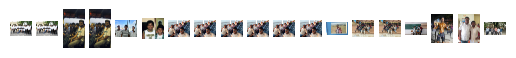

Cluster 1


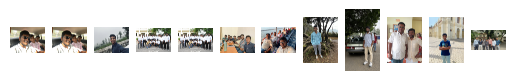

Cluster 2


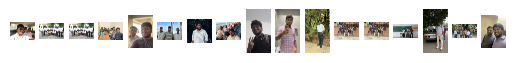

Cluster 3


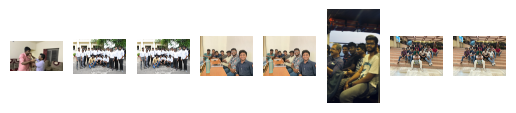

Cluster 4


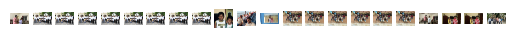

Cluster 5


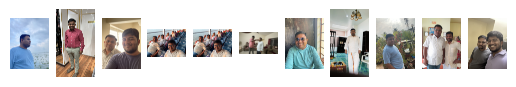

Cluster 6


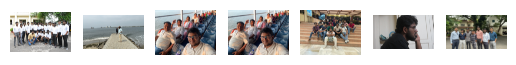

Cluster 7


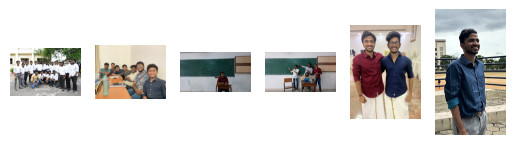

Cluster 8


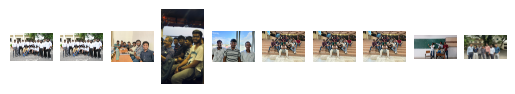

Cluster 9


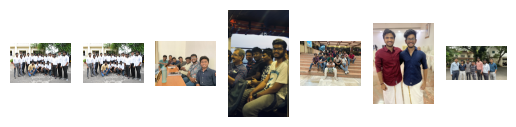

In [401]:
import matplotlib.pyplot as plt
import numpy as np

# cluster_imgs is a list of lists of images
# each list of images is a cluster

for i, cluster in enumerate(cluster_imgs):
    print(f"Cluster {i}")
    fig, axs = plt.subplots(1, len(cluster))
    for j, img in enumerate(cluster):
        axs[j].imshow(img)
        axs[j].axis("off")
    plt.show()
    plt.close()